<a href="https://colab.research.google.com/github/chumpblocckami/AmazonTextClustering/blob/master/TextMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **AMAZON REVIEW DATASET**
Amazon review dataset is a collection of reviews per categories. Each dataset is very large because it spans over years.


# **INDEX**

0. Explorative analysis:
  - Nan's removal: 0.03% 
  - Columns removal: only valuable items selected
1. Sentiment polarity and classification: 
  - Polarity: `TextBlob.sentiment.polarity`
  - Labeling [neg/neu/pos]
2. Preprocessing:
  - Tokenizzazione: `nltk.word_tokenize())`
  - Normalization: `str.lower(), x.translate("","",string.puntuaction)`
  - Stop words removal: `nltk.stopwords(en="english")`
  - Stemming: `PorterStemmer()`
  - Lemmatization: `Lemmatizer()`
3. Structural requirements:
  - Identify the classes
  - Create a custom vocabulary for class detection
4. Clustering
    - TFiDF Matrix
    - Cluster using KMeans
    - Cluster using SpectralClustering



# 0.0 EXPLORATIVE ANALYSIS

In [0]:
link = "http://jmcauley.ucsd.edu/data/amazon/"
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz"

--2019-12-09 20:32:47--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1251876861 (1.2G) [application/octet-stream]
Saving to: ‘Electronics_5.json.gz’

Electronics_5.json. 100%[===================>]   1.17G  11.2MB/s    in 1m 47s  

2019-12-09 20:34:34 (11.2 MB/s) - ‘Electronics_5.json.gz’ saved [1251876861/1251876861]



In [0]:
#Load the dataset
#IN: file .json.gz
#OUT: pandas dataframe
import pandas as pd
import gzip
import json 
import time 

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
time1 = time.time()
df = getDF("Electronics_5.json.gz")
print(f"Tempo impiegato per il caricamento: {(time.time()-time1)*60:.2f}")
df.head()

Tempo impiegato per il caricamento: 15188.51


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [0]:
#Distribuzione rating delle valutazioni
df.groupby("overall")["overall"].count().plot("barh");
#le valutazioni a 5 stelle sono più di dieci volte quelle a 1 stella

#Distribuzione 'verified'
df.groupby("verified")["verified"].count().plot("barh");

#percentuale di nan all'interno delle reviewText
print(f"Percentuale di dati nulli:",data.loc[pd.isna(data["reviewText"])].shape[0] / data.shape[0] * 100,"%")

In [0]:
#togliamo tutti i valori che non sono verified (in quanto pensiamo che non abbiamo acquistato il prodotto)
df = df.loc[df["verified"] == True]

#togliamo tutte le colonne che non ci interessano
data = df.drop(columns="image style unixReviewTime reviewerName asin reviewerID reviewTime verified vote".split())

#eliminazione nan dei reviewText
data = data.loc[pd.isna(data["reviewText"])==False]

Percentuale di dati nulli: 0.021032005744552877 %


# 1.0 SENTIMENT POLARITY AND CLASSIFICATION

## 1.1 Sentiment polarity using TextBlob.sentiment.polarity

In [0]:
#IN: string
#OUT: valore tra -1 e +1 che esprime la polarità della frase, determinata dalla somma della polariti di ogni parola

from textblob import TextBlob
import nltk
nltk.download("movie_reviews")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

def getPolarity(string):
  #parse nan data
    string = str(string)
  #get polarity
    blob = TextBlob(string)
    return blob.sentiment.polarity

data["polarityText"] = data.apply(lambda x:getPolarity(x["reviewText"]),axis=1)

data.to_csv("drive/My Drive/sentiment_polarity.csv") 

## 1.2 Classification using nltk.sentiment.classification

In [0]:
#IN: string
#OUT: 'neg' se string ha indice < 0, 'pos' se string ha indice > 0

from textblob.sentiments import NaiveBayesAnalyzer

def getClassification(string):
 string = str(string)
  return TextBlob(string,analyzer=NaiveBayesAnalyzer()).sentiment.classification

data["textSentiment"] = data.apply(lambda x:getClassification(x["reviewText"]),axis=1)

data.head()

## 1.3 Classification using polarityText

In [0]:
#IN: polarity's value
#OUT: [neg,neut,pos] if polarity < 0, or polarity == 0 or polarity > 0

def getClassification(string):
  string = float(string)
  if (string > 0.0):
    return 'pos'
  elif(string < 0.0):
    return ('neg')
  else:
    return ('neut')

data["textSentimentClassification"] = data.apply(lambda x:getClassification(x["polarityText"]),axis=1)

## OVERVIEW

In [0]:
#Distribuzione sentiment delle review
data.groupby("textSentimentClassification")["textSentimentClassification"].count().plot("bar")

In [0]:
#Analisi distribuzione sentiment polarity e saphiro test for normality

from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

stat,p = shapiro(data["polarityText"].tolist())
print(f"\nStatistica {stat} P-Value {p}")
print("Normalità:",p > 0.05)

plt.figure(dpi=100)
plt.title("Sentiment Polarity")
sns.distplot(data["polarityText"],label="Non Normalizzato");
norm=(data["polarityText"]-data["polarityText"].mean())/data["polarityText"].std()
plt.legend()
sns.distplot(norm,label="Normalizzato");

In [0]:
#DISTRIBUTION OF SENTIMENT POLARITY PER OVERALL

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(dpi=100)
data = data.loc[data["textSentimentClassification"]=='neg']
for i in range(1,len(set(data.overall))+1):
  x = data["polarityText"].loc[data["overall"]!=i]
  sns.distplot(x,label=i,hist=False);
plt.legend()

# 2.0 PREPROCESSING


## 2.1 Normalization

In [0]:
#IN: string
#OUT: string in lowercase, without puntuactions and numbers in it
import string

def getNormalized(string):
    return str.lower(string).strip()
data["reviewTextNormalized"] = data.apply(lambda row:getNormalized(row["reviewText"]),axis=1)

def getNoPuntuactions(strings):
  processed = strings.translate(str.maketrans('','',string.punctuation)).translate(str.maketrans('','','1234567890')).strip()
  output = processed.split(" ")
  return " ".join(output)

data["reviewTextNormalized"] = data.apply(lambda row:getNoPuntuactions(row["reviewTextNormalized"]),axis=1)

## 2.2 Stop words removal

In [0]:
#IN: string
#OUT: string without stopwords (stopwords are words so frequent in a corpus that are not valuable (the, and, to...))
#Before applying this methods, see the distribution of the words in the text.

from collections import Counter
import pprint
tutto = []
tutto = " ".join(data["reviewTextNormalized"].tolist())
pprint.pprint(Counter(nltk.word_tokenize(tutto).most_common(10)) 
pd.DataFrame(Counter(tutto.split(" ")).most_common(100)).plot();

In [0]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stopwords_ = set(stopwords.words('english'))
tutto = [x for x in tutto if x not in stopwords_]
pprint.pprint(Counter(tutto).most_common(10))
pd.DataFrame(Counter(tutto).most_common(100)).plot();

In [0]:
def getStopWords(string):
  output = []
  string = nltk.word_tokenize(str(string))
  stopwords_ = set(stopwords.words('english'))
  output = [x for x in string if x not in stopwords_]
  return " ".join(output)

data["reviewTextStopwords"] = data.apply(lambda x:getStopWords(x["reviewTextNormalized"]),axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.3 Lemmatization

In [0]:
#IN: string
#OUT: lemmatized string
#Lemmatization means to transform a word in his normalized form (better -> good)

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def getLemmatized(string):
  string = str(string)
  out = []
  for word in nltk.word_tokenize(i):
    out.append(lemmatizer.lemmatize(word))
  out = " ".join(out)
  return out

data["reviewTextLemmatized"] = data.apply(lambda row:getLemmatized(row["reviewTextNormalized"]),axis=1)

## 2.4 English words

In [0]:
#IN: string
#OUT: each word in string that are contained in the words dictionary, that has 250.000+ words in english

nltk.download("words")
from nltk.corpus import words
dict_ = set(words.words())
datas = data.reviewTextLemmatized.tolist()
out = []
for i in datas:
  review = []
  for word in nltk.word_tokenize(i):
    if(word in dict_):
      review.append(word)
  out.append(" ".join(review))
data["reviewTextWordnetEnglish"] = out

## 2.5 Stemming

In [0]:
#IN: string
#OUT: stemmed string (stemming is the process that convert a word to its radix (closed --> close))

from nltk.stem import PorterStemmer
ps = PorterStemmer()
def getStemming(string):
  output = []
  for word in string.split(" "):
    output.append(ps.stem(word))
  return " ".join(output)
data["reviewTextStemmed"] = data.apply(lambda row:getStemming(row["reviewTextNormalized"]),axis=1)

## OVERVIEW

In [0]:
#ANALISI LUNGEZZA VOCABOLARI (PROBABILMENTE SI DEVE FAR ANDARE TUTTO PERCHE' NON L'HO SALVATO)
print("Vocabolario non normalizzato ",len(set(nltk.word_tokenize(" ".join(data["ReviewText"].tolist())))))
print("Vocabolario normalizzato ",len(set(nltk.word_tokenize(" ".join(data["ReviewTextNormalized"].tolist())))))
print("Vocabolario senza stopwords ",len(set(nltk.word_tokenize(" ".join(data["reviewTextStopWords"].tolist())))))
print("Vocabolario Lemmatizzato ",len(set(nltk.word_tokenize(" ".join(data["reviewTextLemmatized"].tolist())))))
print("Vocabolario Stemmizzato ",len(set(nltk.word_tokenize(" ".join(data["reviewTextStemmed"].tolist())))))
print("Vocabolario inglese ",len(set(nltk.word_tokenize(" ".join(data["reviewTextWordnetEnglish"].tolist())))))

In [0]:
#ANALISI CONFIGURAZIONE STELLE NELLE RECENSIONI
data.groupby("overall")["overall"].count().plot("barh")

In [0]:
#SAVE THE DATASET
data.to_csv("drive/My Drive/TextMining/datasetPreprocessed.csv")

# 3.0 CLUSTERING

In [0]:
import pandas as pd
data = pd.read_csv("drive/My Drive/TextMining/datasetPreprocessed.csv")

## 3.1 Dictionary Selection

In [0]:
#DICTIONARY SELECTION
ritardo = "late, later, behind schedule, behind time, unpunctually, behind schedule, unpunctual, tardy, overdue, delayed, too late, out of time, backward,".replace(",","").split(" ")
opinioni="bad, ugly, old, poor, inferior, useless, rubbish, pathetic, rotten, miserable, negligent, awful, foulty, terrible, worthless, abominable, unacceptable, inadequate, unsatisfactory, unpleasant, disagreeable, unwelcome, unfortunate, nasty quality, cost".replace(",","").split(" ")
difetto = "defect, bug, crack, deficiency, deformity, error, fault, flaw, glitch, irregularity, lack, mistake, shortage, shortcoming, weakness, birthmark, blot, blotch, break, catch, check, discoloration, drawback, failing, foible, frailty, gap, gremlin, hole, infirmity, kink, knot, mark, marring, patch, rift, scar, scarcity, scratch, seam, second, sin, speck, spot, stain, taint, unsoundness, vice, want, rough spot, weak point, abnormal, damaged, deficient, faulty, flawed, inadequate, insufficient, unhealthy, unsound, amiss, blemished, impaired, imperfect, incomplete, injured, lacking, on the bum, out of order, poor, seconds, sick, subnormal, screen, charger, headphones, usb, jack, keyboard, battery, keylock, webcam, smartphone, laptop".replace(",","").split(" ")

def getFeatureSelection(string):
  string = str(string)
  stringss = nltk.word_tokenize(string)
  out = []
  for i in stringss:
    if i in ritardo or i in opinioni or i in difetto:
      out.append(i)
  return " ".join(out)

data["reviewTextFeatureSelection"] = data.apply(lambda row:getFeatureSelection(row["reviewTextLemmatized"]),axis=1)
print("%Review cutted",len(data.loc[data["reviewTextFeatureSelection"]==""])/len(data)*100)

## 3.2 TFIDF Rappresentation

In [0]:
#TFIDF 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#solo valori che ci interessano
data = data.loc[data["textSentimentClassification"]=='neg'].loc[data["overall"]!=5].dropna()
texts = data.loc[data["reviewTextFeatureSelection"]!=""]["reviewTextFeatureSelection"].tolist() #qua capire quale testo preprocessato ci interessa

vectorizer = TfidfVectorizer(use_idf=False,smooth_idf=False,).fit_transform(texts)

#feature selection che toglie feature con varianza bassa
from sklearn.feature_selection import VarianceThreshold
feature_selected = VarianceThreshold().fit_transform(vectorizer)

print("Vanilla: ",len(set(texts)))
print("Without feature selection: ",vectorizer.shape)
print("With feature selection: ",feature_selected.todense().shape)

#qua c'è da fare un tuning per esempio con un 
#[VarianceThreshold(x).fit_transform(vectorizer) for x in range(0,1,0.1)]

#qua c'è da fare un tuning per esempio con un 
#[VarianceThreshold(x).fit_transform(vectorizer) for x in range(0,1,0.1)]

## 3.3 Clustering

In [0]:
from sklearn.cluster import MiniBatchKMeans
cls = MiniBatchKMeans(n_clusters=3,random_state = random_state)
cls.fit(feature_selected)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
features = feature_selected
# reduce the features to 2D
pca = PCA(n_components=2, random_state=420)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

#plotting the data
plt.figure(dpi=100)
plt.title("Clustering")
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features),)#label=cmaps[cls.predict(features)]);
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b');
plt.legend(bbox_to_anchor=(1,1))

## OVERVIEW

In [0]:
...

#COSE FATTE MA DA DEFINIRE MEGLIO INSIEME

In [0]:
#silhouette_score() in base aumentando il numero di cluster
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
scores = []
ranges=range(2,100,1)
for i in ranges:
  cls = MiniBatchKMeans(n_clusters=i,random_state = 420)
  cls.fit(feature_selected)
  scores.append(silhouette_score(feature_selected, labels=cls.predict(feature_selected),sample_size=1000))

plt.plot(ranges,scores)

In [0]:
#visualizzazioni varie sui cluster
data["Cluster"] = cls.labels_
data.groupby("Cluster")["Cluster"].count().plot("pie")

In [0]:
#differenza delle parole piu' comuni tra cluster

zero = [str(x) for x in nltk.word_tokenize(" ".join(data.loc[data["Cluster"]==0]["reviewTextWordnetEnglish"]))] #qua prendere in considerazione un testo che sia quello su cui è stato fatto il clustering
uno = [str(x) for x in nltk.word_tokenize(" ".join(data.loc[data["Cluster"]==1]["reviewTextWordnetEnglish"]))]
due = [str(x) for x in nltk.word_tokenize(" ".join(data.loc[data["Cluster"]==2]["reviewTextWordnetEnglish"]))]

zero = set(zero)
uno = set(uno)
due = set(due)

zero_uno=[x for x in zero if x not in uno]
zero_due=[x for x in zero if x not in due]
uno_due=[x for x in uno if x not in due]

In [0]:
import nltk
from nltk import word_tokenize
nltk.download("punkt")
from collections import Counter
pd.DataFrame(Counter([nltk.word_tokenize(x) for x in data.loc[data["Cluster"]==2]["reviewTextStopwords"].tolist()])).plot()

In [0]:
#TUNING DEI CLUSTER PER GIF (aumento numero di cluster)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

random_state = 420
texts = [str(x[6]) for x in data.dropna().values[:10000]]

for i in range(2,10):
  vec = TfidfVectorizer()
  vec.fit(texts)

  features = vec.transform(texts)
  cls = MiniBatchKMeans(n_clusters=i, random_state=random_state)
  cls.fit(features)
  # reduce the features to 2D
  pca = PCA(n_components=2, random_state=random_state)
  reduced_features = pca.fit_transform(features.toarray())

  # reduce the cluster centers to 2D
  reduced_cluster_centers = pca.transform(cls.cluster_centers_)

  #get cluster metrics
  scores = []
  score = round(silhouette_score(features, labels=cls.predict(features)),3)
  scores.append(score)
  #homogeneity_score(df.label, cls.predict(features)) non sappiamo le labels

  #plotting the data
  plt.figure(dpi=100)
  plt.title("{0}* Custer".format(i))
  plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features));
  plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b');
  plt.annotate(f"Score: \n{score}",xy=(0.4,0.5),size=15,c="red")
  plt.tight_layout()
  plt.savefig("drive/My Drive/TextMining/images/"+str(i)+".png")

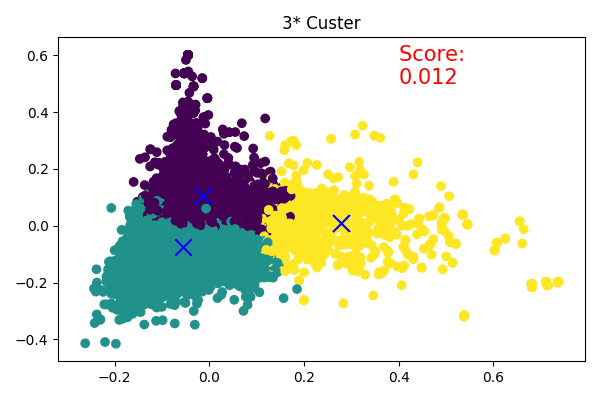

In [0]:
#CREATING GIF
import imageio
import os
picture = ['drive/My Drive/TextMining/images/'+str(x) for x in os.listdir('drive/My Drive/TextMining/images/') if ".png" in x]
images = []
for filename in picture:
    images.append(imageio.imread(filename))
imageio.mimsave('drive/My Drive/TextMining/Cluster.gif', images,duration=0.5)
#visualizing the results
from IPython.display import Image
with open("drive/My Drive/TextMining/Cluster.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))

In [0]:
#parte massi
# trovare prima modo di rappresentare e poi modo di sfoltire con criterio le feature di rappresentazione del testo

# RAPPRESENTAZIONE

# offre una rappresentazione di conteggio dei token all'interno delle recensioni, forse meglio nel nostro caso dato che sono recensioni brevi
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer
#min df non lo metterei perché forse essendo testi molto brevi potrebbe essere controproducente / max df invece si, vediamo poi quanto alto
CountVectorizer(input = 'content', lowercase = True, ngram_range = (1,3), max_df = 0.8, stop_words='english' )
#per le stop words, se vogliamo toglierne qualcuna in più, possiamo costruire una lista e riportare, però farlo prima della riga sopra, che se no i bigrammi con dentro la stop
#words, non li becchiamo.
CountVectorizer(input = 'content', stop_words='nome_lista' )

#### NB quando parliamo di document frequency df max e min, intendiamo la percentuale di documenti che hanno al proprio interno una certa parola
####    quindi cerchiamo di prendere quelle parole che sono poco presenti all'interno del nosrto corups di documenti.


#offre una rappresentazione con tf-idf dei termini 
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
TfIdfVectorizer(input='content', lowercase = True, stop_words = 'english / o altra lista di parole da togliere', ngram_range = (1,2), max_df = 0.8, min_df = 0,)



#per usarli, o passi i dati input, o fit_transform
vectorizer = TfIdfVectorizer(parametri)
data_precessed = fit_transform(data)


# RIDUZIONE DELLE FEATURE
# SVD
svd = TruncatedSVD(n_componenets = numero, n_iter = 5)
# - algorithm è l'algoritmo che usa l'SVD, non so quanto sia interessante
# - n_iter, sono il numero di iterazioni che sono usate da svd per trovare le componenti più importanti

#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD


normalizer = Normalizer(norm = '', copy=False)
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer
# - norm è il tipo di valore che vogliamo usare per normalizzare ogni campione non nullo, possibili valori sono ‘l1’, ‘l2’, or ‘max’
# - copy indica se vogliamo anche il vettore originale o solo quello normalizzato

lsa = make_pipeline(svd, normalizer)

data_reduced = lsa.fit_transform(data_processed)

#DICTIONARY LEARNING

sklearn.decomposition.DictionaryLearning()

n_componenetsssono gli elementi del dizionario da estrarre

#SPARSE PCA

sklearn.decomposition.SparsePCA()

#link utili
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
https://towardsdatascience.com/feature-engineering-with-nltk-for-nlp-and-python-82f493a937a0


http://www.nltk.org/howto/collocations.html



In [0]:
#PER VALUTAZIONI SULLA SILUHETTE, E PER CLUSTERIZZARE COME PUNTO DI PARTENZA
#GUARDARE QUESTO LINK SE VOLETE

#https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

In [0]:
# PROBLEMI
# massi
# RITARDO - late, later, behind schedule, behind time, unpunctually, behind schedule, unpunctual, tardy, overdue, delayed, too late, out of time, backward, 

# OPINIONI - bad, ugly, old, poor, inferior, useless, rubbish, pathetic, rotten, miserable, negligent, awful, foulty, terrible, worthless, abominable, unacceptable, inadequate, unsatisfactory, unpleasant, disagreeable, unwelcome, unfortunate, nasty
# quality, cost, 

# DIFETTO AD UNA PARTE - defect, bug, crack, deficiency, deformity, error, fault, flaw, glitch, irregularity, lack, mistake, shortage, shortcoming, weakness, birthmark, blot, blotch, break, catch, check, discoloration, drawback, failing, foible, frailty, gap, gremlin, hole, infirmity, kink, knot, mark, marring, patch, rift, scar, scarcity, scratch, seam, second, sin, speck, spot, stain, taint, unsoundness, vice, want, rough spot, weak point
#abnormal, damaged, deficient, faulty, flawed, inadequate, insufficient, unhealthy, unsound, amiss, blemished, impaired, imperfect, incomplete, injured, lacking, on the bum, out of order, poor, seconds, sick, subnormal
#screen, charger, headphones, usb, jack, keyboard, battery, keylock, webcam, smartphone, laptop
# parti che potrebbero essere difettose: screen, keyboard, battery, slow, RAM, ROM, SSD, HDD, cable, 
# charger, memory

